<a href="https://colab.research.google.com/github/Phrmth/New/blob/master/Resnet18_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import tensor
from torch import nn
import torch.nn.functional as F
import torch
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [0]:
# setting cuda device 
if torch.cuda.is_available():
 device = torch.device("cuda")
else : device = torch.device("cpu")

# Hyper-parameters 
num_epochs = 20
batch_size = 64
learning_rate = 0.001


# train_transforms = transforms.Compose(
#     [
#     #  transforms.ToPILImage(),
#      transforms.Resize((224,224)),
#      transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
#      transforms.CenterCrop(224),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=(0.5,), std=(0.5,))])

# val_test_transforms = transforms.Compose(
#     [
#     #  transforms.ToPILImage(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [3]:
# Data
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform = transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform = transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size*2, 
                                          shuffle=False)

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
x,_= next(iter(train_loader))

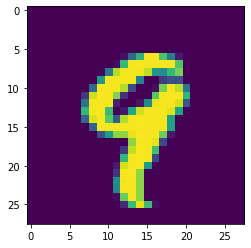

In [7]:
plt.imshow(x[0].view(28,28))

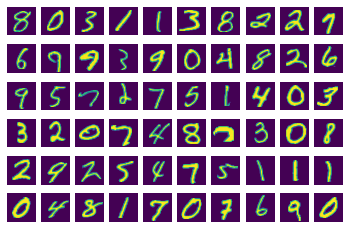

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(x[index].numpy().squeeze())

In [0]:
# importing resnet18 model

from torchvision import models
resnet18 = models.resnet18()

In [0]:
# correcting the first input layer 3-channel to 1-channel input layer
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(512,10)

In [11]:
# checking output shapes for each layer
from torchvision import models
from torchsummary import summary

summary(resnet18.cuda(), (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

In [0]:
# Model fit - Train and validation scores per epoch !
train_loss = []
valid_loss = []
ep, learnrate , err , err_v = [],[],[],[]

def fit(epochs, model , train_loader, test_loader, opt, loss_func ):
  
  model.to(device)
  curr_lr = learning_rate
  for epoch in range(epochs):
    
    for i,(xb, yb) in enumerate(train_loader):
      # print(xb.shape)
      model.train()
      opt.zero_grad()
      xb,yb = xb.to(device),yb.to(device)

      pred = model(xb)
      loss = loss_func(pred,yb)
      loss.backward()
      opt.step()

    train_loss.append(loss)
      # with torch.no_grad():
      #   for p in model.parameters(): p-= p.grad * lr

    with torch.no_grad():
      for xv,yv in test_loader:
        
        xv,yv = xv.to(device),yv.to(device)
        pred = model(xv)
        loss_v = loss_func(pred,yv)
        ep = ((torch.argmax(pred,dim = 1) == yv).sum().item())/yv.size(0)
      valid_loss.append(loss_v)


        # Decay learning rate
    if (epoch+1) % 3 == 0:
      curr_lr /= 2
      update_lr(opt, curr_lr)

    
    if (epoch+1) % 1 == 0: 
      print(f"Epoch{epoch} : Train Loss {loss.item()} , Valid Loss {loss_v.item()}. Accuracy {ep}")
  
  return train_loss, valid_loss


In [0]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [15]:
# Training and Testing the model for n epochs ! 
%time train_loss, valid_loss = fit(7, resnet18, train_loader, test_loader, opt, loss_fn)

Epoch0 : Train Loss 0.2774849534034729 , Valid Loss 0.0013698041439056396. Accuracy 1.0
Epoch1 : Train Loss 0.019003048539161682 , Valid Loss 0.0050483644008636475. Accuracy 1.0
Epoch2 : Train Loss 0.05227178707718849 , Valid Loss 0.00022292137145996094. Accuracy 1.0
Epoch3 : Train Loss 0.0009067803621292114 , Valid Loss 8.654594421386719e-05. Accuracy 1.0
Epoch4 : Train Loss 0.06722463667392731 , Valid Loss 0.00012829899787902832. Accuracy 1.0
Epoch5 : Train Loss 0.0738072469830513 , Valid Loss 0.0009922385215759277. Accuracy 1.0
Epoch6 : Train Loss 0.010062813758850098 , Valid Loss 2.4318695068359375e-05. Accuracy 1.0
CPU times: user 2min 1s, sys: 4.24 s, total: 2min 5s
Wall time: 2min 6s


In [16]:
# Final testing on validation data of 10000 samples. 
with torch.no_grad():
  correct = 0
  total = 0
  resnet18 = resnet18.to(device)
  # print(model)
  for xv,yv in test_loader:
    xv,yv = xv.to(device),yv.to(device)
    pred = resnet18(xv)
    # print(pred)
    # _, predicted = torch.max(pred.data, 1)
    total += yv.size(0)
    # print("correct per batch",(torch.argmax(pred,dim = 1) == yv).sum())
    correct += (torch.argmax(pred,dim = 1) == yv).sum()
    # print(f"Accuracy per batch is {((torch.argmax(pred,dim = 1) == yv).sum().item())/yv.size(0)}")
  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 99 %


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
